In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
%matplotlib inline

In [3]:
PATH_DATA = './PhonePi/data/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]

100%|████████████████████████████████████████| 13/13 [00:01<00:00,  8.00it/s]


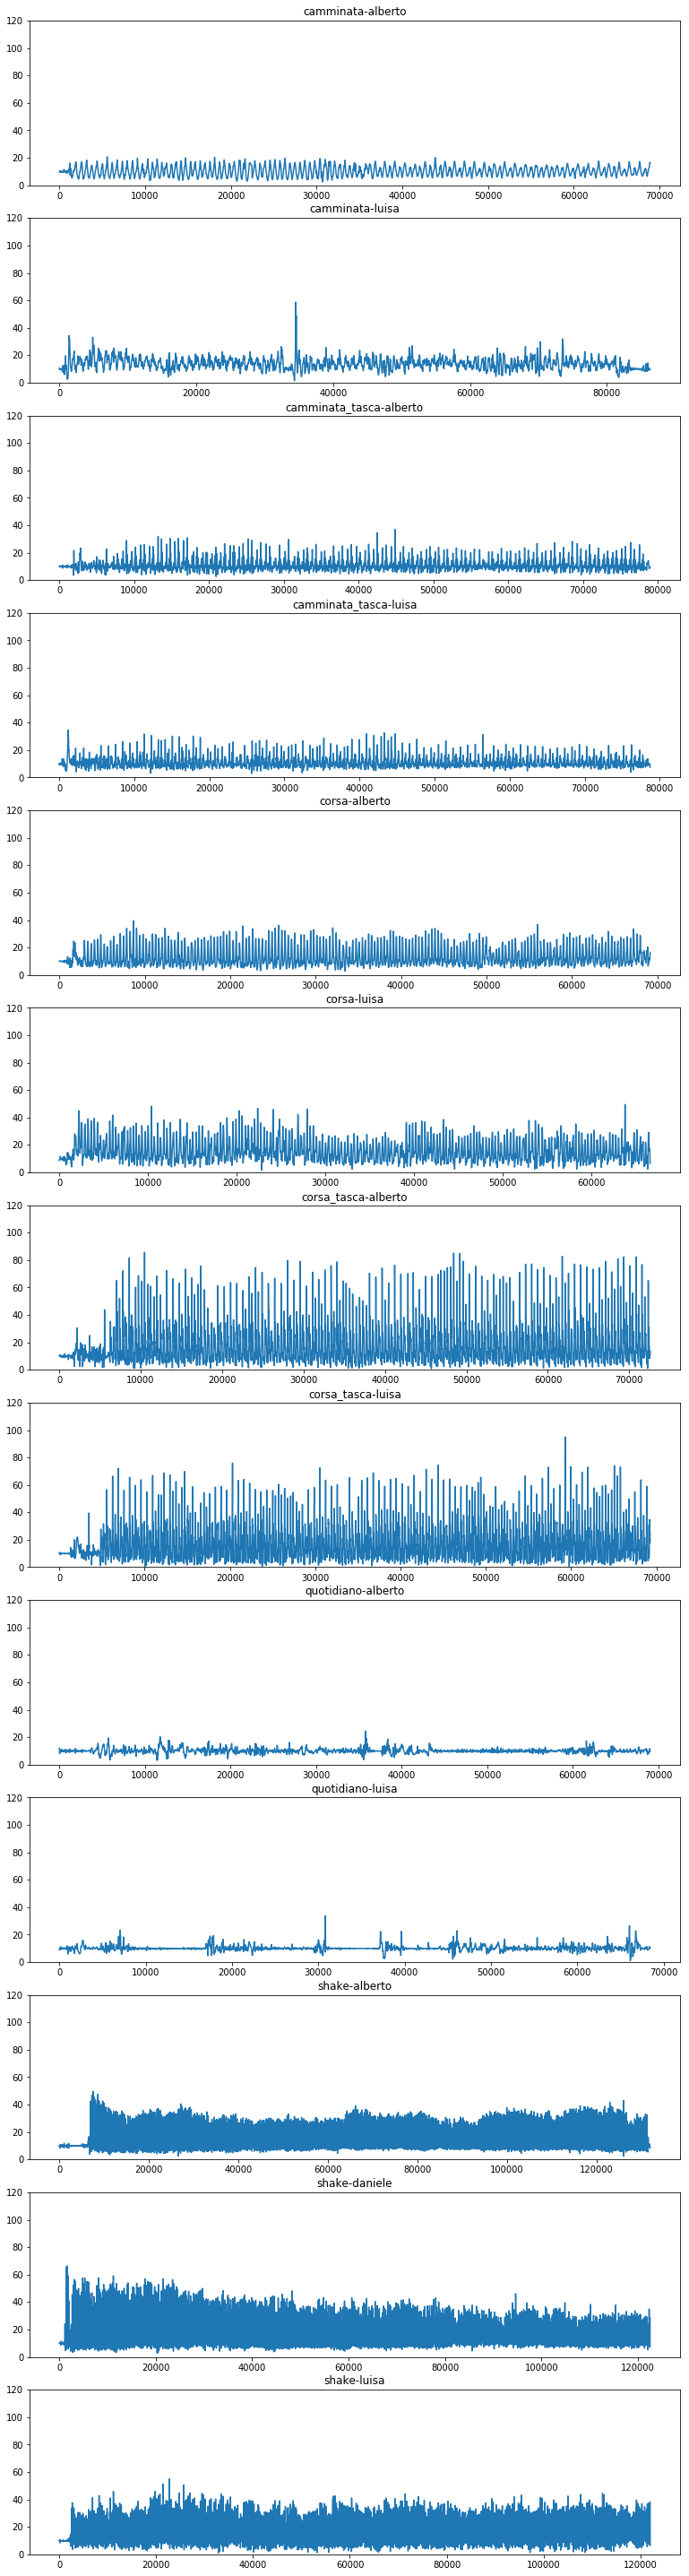

In [4]:
plt.figure(figsize=(13,4*len(DIR)))
nrow = len(DIR)
for i in tqdm.tqdm(range(len(DIR))):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
    data["t"] = data["t"] - data["t"].iloc[0]
    data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))]
    data["a"] = (data["ax"]**2 + data["ay"]**2 + data["az"]**2)**0.5
    ax = plt.subplot(nrow, 1, i+1, ylim=(0,120))
    ax.set_title(DIR[i].split("/")[-1])
    plt.plot(data["t"],data["a"])
    
plt.show()

In [ ]:
tipo=[dir.split("/")[-1] for dir in DIR]
tipo

In [ ]:
tipo=[dir.split("-")[0] for dir in tipo]
tipo

In [ ]:
nomi_colonna=["user","azione"]
nomi_colonna.extend(["a"+str(i) for i in range(200)])
nomi_colonna

In [ ]:
X=pd.DataFrame(columns=nomi_colonna)

for i in range(len(DIR)):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"]) # lettura dati
    data["t"] = data["t"] - data["t"].iloc[0] # t0 = 0
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))] # tolti i primi e ultimi 7 secondi
    data.reset_index(drop=True, inplace=True) # ripristinati gli indici da 0 in avanti
    data["a"] = (data["ax"]**2 + data["ay"]**2 + data["az"]**2)**0.5 # accelerazione in modulo
    nome = [data.user[j] for j in range(0,len(data)-200,200)] # intervalli di 200*10ms
    tipologia=[tipo[i]]*len(nome)
    righe=[[nome[j],tipologia[j]] for j in range(len(nome))]
    [righe[j].extend(list(data.a[j*200:(j+1)*200])) for j in range(len(nome))]
    X=pd.concat([X,pd.DataFrame(righe,columns=nomi_colonna)],ignore_index=True) # ignore_index=T per avere indici consecutivi

In [ ]:
y = X.azione
X = X.drop("azione", axis=1)

In [ ]:
X.to_pickle("X-2s.pkl")
y.to_pickle("y-2s.pkl")